<a href="https://colab.research.google.com/github/ykitaguchi77/CorneAI/blob/main/YOLOv5_CutMix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**YOLOv5_CutMix**

In [1]:
import os

# prompt: gdriveをマウント
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
folder_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/Cutmix_mixed_img'
os.listdir(folder_path)


['back_normal',
 'back_bullous',
 'back_infection',
 'back_tumor',
 'back_deposit',
 'back_scar',
 'back_non-infection',
 'back_apac',
 'back_lens-opacity']

#**Underbar to Hyphen**

lens_opacity --> lens-opacity

In [3]:
import os

def rename_item(old_path):
    directory, item_name = os.path.split(old_path)
    new_name = item_name
    if "lens_opacity" in item_name:
        new_name = new_name.replace("lens_opacity", "lens-opacity")
    if "non_infection" in item_name:
        new_name = new_name.replace("non_infection", "non-infection")

    if new_name != item_name:
        new_path = os.path.join(directory, new_name)
        os.rename(old_path, new_path)
        print(f"Renamed: {item_name} -> {new_name}")
        return new_path
    return old_path

def rename_files_and_directories(folder_path):
    for root, dirs, files in os.walk(folder_path, topdown=False):
        # まずファイルの名前を変更
        for file in files:
            old_path = os.path.join(root, file)
            rename_item(old_path)

        # 次にディレクトリの名前を変更
        for dir in dirs:
            old_path = os.path.join(root, dir)
            new_path = rename_item(old_path)

            # ディレクトリ名が変更された場合、親ディレクトリのパスも更新
            if new_path != old_path:
                index = dirs.index(dir)
                dirs[index] = os.path.basename(new_path)

# 使用例
folder_path = "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/Cutmix_mixed_img"  # ここに実際のフォルダパスを指定してください
rename_files_and_directories(folder_path)

#**inference YOLOv5**

In [4]:
%cd /content
!pip uninstall deep_utils -y
!pip install -U git+https://github.com/pooya-mohammadi/deep_utils.git --q
!pip install torch --q
!pip install torchvision --q
!pip install -U opencv-python --q
print("[INFO] To use new installed version of opencv, the session should be restarted!!!!")

!git clone https://github.com/pooya-mohammadi/yolov5-gradcam

/content
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 10.4 MB/s eta 0:00:00
[INFO] To use new installed version of opencv, the session should be restarted!!!!
Cloning into 'yolov5-gradcam'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 134 (delta 29), reused 36 (delta 13), pack-reused 68
Receiving objects: 100% (134/134), 6.95 MiB | 26.84 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [5]:
import gc
gc.collect()

44

In [6]:
os.chdir('/content/yolov5-gradcam')

In [7]:
#################
#################

import numpy as np
from deep_utils.utils.box_utils.boxes import Box
import torch
from models.experimental import attempt_load
from utils.general import xywh2xyxy
from utils.datasets import letterbox
import cv2
import time
import torchvision
import torch.nn as nn
from utils.metrics import box_iou

class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode='eval',
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms
        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")
        self.model.requires_grad_(True)
        self.model.to(device)
        if self.mode == 'train':
            self.model.train()
        else:
            self.model.eval()
        # fetch the names
        if names is None:
            print('[INFO] fetching names from coco file')
            self.names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
                          'traffic light',
                          'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
                          'cow',
                          'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase',
                          'frisbee',
                          'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
                          'surfboard',
                          'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
                          'apple',
                          'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
                          'couch',
                          'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                          'keyboard', 'cell phone',
                          'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                          'teddy bear',
                          'hair drier', 'toothbrush']
        else:
            self.names = names

        # preventing cold start
        img = torch.zeros((1, 3, *self.img_size), device=device)
        self.model(img)

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        """Runs Non-Maximum Suppression (NMS) on inference and logits results

        Returns:
             list of detections, on (n,6) tensor per image [xyxy, conf, cls] and pruned input logits (n, number-classes)
        """

        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Checks
        assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
        assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

        # Settings
        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            # Apply constraints
            # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]
            # Cat apriori labels if autolabelling
            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]  # box
                v[:, 4] = 1.0  # conf
                v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
                x = torch.cat((x, v), 0)

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
            # log_ *= x[:, 4:5]
            # Box (center x, center y, width, height) to (x1, y1, x2, y2)
            box = xywh2xyxy(x[:, :4])

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                # log_ = x[:, 5:]
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]
            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]
            if (time.time() - t) > time_limit:
                print(f'WARNING: NMS time limit {time_limit}s exceeded')
                break  # time limit exceeded

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):

        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None,
                                                      agnostic=self.agnostic)
        self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in
                                                                        range(4)]
        for i, det in enumerate(prediction):  # detections per image
            if len(det):
                for *xyxy, conf, cls in det:
                    # xyxyの値を修正
                    xyxy[0] = max(0, xyxy[0])
                    xyxy[1] = max(0, xyxy[1])
                    xyxy[2] = min(img_size, xyxy[2])
                    xyxy[3] = min(img_size, xyxy[3])

                    bbox = Box.box2box(xyxy,
                                       in_source=Box.BoxSource.Torch,
                                       to_source=Box.BoxSource.Numpy,
                                       return_int=True)
                    self.boxes[i].append(bbox)
                    self.confidences[i].append(round(conf.item(), 2))
                    cls = int(cls.item())
                    self.classes[i].append(cls)
                    if self.names is not None:
                        self.class_names[i].append(self.names[cls])
                    else:
                        self.class_names[i].append(cls)
        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        img = np.array([self.yolo_resize(im, new_shape=self.img_size)[0] for im in im0])
        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img


In [8]:
import os
import time
import numpy as np
# from models.gradcam import YOLOV5GradCAM
#from models.yolo_v5_object_detector import YOLOV5TorchObjectDetector
import cv2
from google.colab.patches import cv2_imshow
from deep_utils import Box, split_extension
import gc

import torch
import torch.nn.functional as F

# クラス名リストを指定
names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]

# 以下の関数は変更なし
def get_res_img(bbox, masks, res_img):
    for mask in masks:
        mask = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
        heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
        n_heatmat = (Box.fill_outer_box(heatmap, bbox) / 255).astype(np.float32)
        res_img = res_img / 255
        res_img = cv2.add(res_img, n_heatmat)
        res_img = (res_img / res_img.max())
    return res_img, n_heatmat

def put_text_box(bbox, cls_name, res_img):
    x1, y1, x2, y2 = bbox
    cv2.imwrite('temp.jpg', (res_img * 255).astype(np.uint8))
    res_img = cv2.imread('temp.jpg')
    res_img = Box.put_box(res_img, bbox)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2.0
    color = (0, 255, 0)  # Green color in BGR format
    thickness = 2

    text_size, _ = cv2.getTextSize(cls_name, font, font_scale, thickness)
    text_x = 10
    text_y = text_size[1] + 10

    cv2.putText(res_img, cls_name, (text_x, text_y), font, font_scale, color, thickness)

    return res_img

def concat_images(images):
    w, h = images[0].shape[:2]
    width = w
    height = h * len(images)
    base_img = np.zeros((width, height, 3), dtype=np.uint8)
    for i, img in enumerate(images):
        base_img[:, h * i:h * (i + 1), ...] = img
    return base_img

def find_yolo_layer(model, layer_name):
    hierarchy = layer_name.split('_')
    target_layer = model.model._modules[hierarchy[0]]

    for h in hierarchy[1:]:
        target_layer = target_layer._modules[h]
    return target_layer

# YOLOV5GradCAMクラスを更新
class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640), method='gradcam'):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.method = method
        self.cls_names = []  # クラス名を格納するリストを初期化

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None

        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        target_layer = find_yolo_layer(self.model, layer_name)
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        device = 'cuda' if next(self.model.model.parameters()).is_cuda else 'cpu'
        self.model(torch.zeros(1, 3, *img_size, device=device))


    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()
        preds, logits = self.model(input_img)

        _, top3_indices = torch.topk(logits[0], k=3)

        if top3_indices.numel() > 0:
            preds[1][0] = top3_indices.tolist()[0]
            preds[2][0] = [names[i] for i in preds[1][0]]
            self.cls_names = preds[2][0]
        else:
            self.cls_names = []

        if self.method == 'eigencam':
            saliency_map = self._eigencam()
            saliency_maps.append(saliency_map)
        else:
            for cls, cls_name in zip(preds[1][0], preds[2][0]):
                if class_idx:
                    score = logits[0][0][cls]
                else:
                    score = logits[0][0].max()
                self.model.zero_grad()
                score.backward(retain_graph=True)
                gradients = self.gradients['value']
                activations = self.activations['value']
                b, k, u, v = gradients.size()

                if self.method == 'gradcam':
                    weights = self._gradcam_weights(gradients, b, k)
                elif self.method == 'gradcampp':
                    weights = self._gradcampp_weights(gradients, activations, score, b, k, u, v)

                saliency_map = (weights * activations).sum(1, keepdim=True)
                saliency_map = F.relu(saliency_map)
                saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
                saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
                saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
                saliency_maps.append(saliency_map)

        return saliency_maps, logits, preds, self.cls_names

    def _gradcam_weights(self, gradients, b, k):
        alpha = gradients.view(b, k, -1).mean(2)
        return alpha.view(b, k, 1, 1)

    def _gradcampp_weights(self, gradients, activations, score, b, k, u, v):
        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
            activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
        alpha = alpha_num.div(alpha_denom + 1e-7)
        positive_gradients = F.relu(score.exp() * gradients)
        weights = (positive_gradients * alpha).view(b, k, u*v).sum(-1).view(b, k, 1, 1)
        return weights

    def _eigencam(self):
        activations = self.activations['value']
        b, k, u, v = activations.size()
        activations_reshaped = activations.view(b, k, -1)

        # Compute covariance matrix
        cov = activations_reshaped @ activations_reshaped.transpose(-1, -2)
        cov /= (u * v)

        # Compute eigenvectors
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)

        # Select the eigenvector corresponding to the largest eigenvalue
        leading_eigenvector = eigenvectors[..., -1].unsqueeze(-1)

        # Compute EigenCAM
        eigen_cam = (activations_reshaped.transpose(-1, -2) @ leading_eigenvector).view(b, u, v)
        eigen_cam = F.relu(eigen_cam)

        # Normalize
        eigen_cam_min, eigen_cam_max = eigen_cam.min(), eigen_cam.max()
        eigen_cam = (eigen_cam - eigen_cam_min) / (eigen_cam_max - eigen_cam_min + 1e-8)

        return eigen_cam.unsqueeze(1)

    def __call__(self, input_img):
        return self.forward(input_img)

In [ ]:
import os
import torch
import cv2
import numpy as np
import time
import torchvision
from utils.general import xywh2xyxy
from utils.datasets import letterbox
from utils.metrics import box_iou
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box
import torch.nn as nn

class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode='eval',
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms
        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")
        self.model.requires_grad_(True)
        self.model.to(device)
        if self.mode == 'train':
            self.model.train()
        else:
            self.model.eval()
        self.names = names if names else self.model.names

        # Prevent cold start
        img = torch.zeros((1, 3, *self.img_size), device=device)
        self.model(img)

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Settings
        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, nc), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

            # Box (center x, center y, width, height) to (x1, y1, x2, y2)
            box = xywh2xyxy(x[:, :4])

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]

            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Apply finite constraint
            # if not torch.isfinite(x).all():
            #     x = x[torch.isfinite(x).all(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            if (time.time() - t) > time_limit:
                print(f'WARNING: NMS time limit {time_limit}s exceeded')
                break  # time limit exceeded

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None, agnostic=self.agnostic)
        self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in range(4)]
        for i, det in enumerate(prediction):  # detections per image
            if len(det):
                for *xyxy, conf, cls in det:
                    xyxy[0] = max(0, xyxy[0])
                    xyxy[1] = max(0, xyxy[1])
                    xyxy[2] = min(self.img_size[0], xyxy[2])
                    xyxy[3] = min(self.img_size[1], xyxy[3])

                    bbox = Box.box2box(xyxy,
                                       in_source=Box.BoxSource.Torch,
                                       to_source=Box.BoxSource.Numpy,
                                       return_int=True)
                    self.boxes[i].append(bbox)
                    self.confidences[i].append(round(conf.item(), 2))
                    cls = int(cls.item())
                    self.classes[i].append(cls)
                    self.class_names[i].append(self.names[cls])
        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        img = np.array([self.yolo_resize(im, new_shape=self.img_size)[0] for im in im0])
        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

def process_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    torch_img = model.preprocessing(img)

    with torch.no_grad():
        prediction, logits = model(torch_img)

    # Top 1 クラスとその確率を取得
    if len(prediction[2][0]) > 0:
        top_class = prediction[2][0][0]
        top_prob = prediction[3][0][0]
        return top_class, top_prob
    else:
        return "No detection", 0.0

#**YOLOv5_GradCAM**

In [19]:
def main(img_path, method):
    input_size = (img_size, img_size)
    img = cv2.imread(img_path)
    model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)
    torch_img = model.preprocessing(img[..., ::-1])

    saliency_method = YOLOV5GradCAM(model=model, layer_name=target_layer, img_size=input_size, method=method)

    tic = time.time()
    masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)
    print("total time:", round(time.time() - tic, 4))

    result = torch_img.squeeze(0).mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).detach().cpu().numpy()
    result = result[..., ::-1]  # convert to bgr
    images = [result]

    for i in range(len(masks)):
        res_img = result.copy()
        for j, mask in enumerate(masks[i]):
            bbox = boxes[0][j]
            res_img, _ = get_res_img(bbox, [mask], res_img)
            res_img = put_text_box(bbox, cls_names[i], res_img)
        images.append(res_img)

    final_image = concat_images(images)
    img_name = split_extension(os.path.split(img_path)[-1], suffix=f'-res-{method}')
    output_path = f'{output_dir}/{img_name}'
    os.makedirs(output_dir, exist_ok=True)
    print(f'[INFO] Saving the final image at {output_path}')
    cv2_imshow(final_image)

def folder_main(folder_path, method):
    input_size = (img_size, img_size)
    model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)

    #####ファイル名を数字でソート################
    file_list = os.listdir(folder_path)
    #############################################

    for item in file_list:
        img_path = os.path.join(folder_path, item)
        img_basename = os.path.basename(img_path)
        print(f"Processing image: {img_basename}")
        img = cv2.imread(img_path)

        # 元の画像の縦横比を維持しながらリサイズ
        h, w = img.shape[:2]
        if h > w:
            new_h, new_w = img_size, int(img_size * w / h)
        else:
            new_h, new_w = int(img_size * h / w), img_size
        img = cv2.resize(img, (new_w, new_h))

        # パディングを追加して640×640pxにする
        delta_w = img_size - new_w
        delta_h = img_size - new_h
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        torch_img = model.preprocessing(img[..., ::-1])

        saliency_method = YOLOV5GradCAM(model=model, layer_name=target_layer, img_size=input_size, method=method)

        masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)
        print(f"boxes: {boxes}")

        result = torch_img.squeeze(0).mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).detach().cpu().numpy()
        result = result[..., ::-1]  # convert to bgr
        images = [result]

        for i in range(len(masks)):
            res_img = result.copy()
            for j, mask in enumerate(masks[i]):
                bbox = boxes[0][j]
                res_img, _ = get_res_img(bbox, [mask], res_img)
                res_img = put_text_box(bbox, cls_names[i], res_img)
            images.append(res_img)

        final_image = concat_images(images)
        img_name = split_extension(os.path.split(img_path)[-1], suffix=f'-res-{method}')
        output_path = f'{output_dir}/{img_name}'
        os.makedirs(output_dir, exist_ok=True)
        print(f'[INFO] Saving the final image at {output_path}')

        cv2.imwrite(output_path, final_image)
        #cv2_imshow(final_image)

        # メモリ解放
        del saliency_method, masks, logits, boxes, images, final_image
        gc.collect()

if __name__ == '__main__':
    folder_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/Cutmix_mixed_img'
    img_dir = os.path.join(folder_path, os.listdir(folder_path)[0])

    model_path = "/content/drive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    device = 'cpu'  # 'cuda' または 'cpu'
    img_size = 640  # 入力画像サイズ
    #target_layer = 'model_17_cv3_conv'  # GradCAM を適用するレイヤー
    #target_layer = 'model_20_cv3_conv'  # GradCAM を適用するレイヤー
    target_layer = 'model_23_cv3_conv'  # GradCAM を適用するレイヤー
    #target_layer = 'model_23_cv3_act'  # GradCAM を適用するレイヤー  →デフォルト
    #target_layer = 'model_23_m_0_cv2_conv'  # GradCAM を適用するレイヤー
    #target_layer = 'model_23_m_0_cv2_act'  # GradCAM を適用するレイヤー
    #target_layer = 'model_24_m_1'  # GradCAM を適用するレイヤー
    #target_layer = 'model_24_m_2'  # GradCAM を適用するレイヤー
    img_path = img_dir
    #output_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam++_img_slit'  # 出力ディレクトリ
    output_dir = '/content/outputs'  # 出力ディレクトリ


    # GradCAMとGradCAM++の両方を実行
    #for method in ['gradcam', 'gradcampp', 'eigencam']:
    for method in ['gradcam', 'gradcampp']:
    #for method in ['gradcampp']:
        print(f"{method.upper()}を実行中:")
        if os.path.isdir(img_path):
            folder_main(img_path, method)
        else:
            main(img_path, method)


NotADirectoryError: [Errno 20] Not a directory: '/content/apac_5_apac.png'

#**GradCAMなしバージョン**

In [9]:
import os
import torch
import cv2
import numpy as np
import time
import torchvision
from utils.general import xywh2xyxy
from utils.datasets import letterbox
from utils.metrics import box_iou
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box
import torch.nn as nn

class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode='eval',
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms
        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")
        self.model.requires_grad_(True)
        self.model.to(device)
        if self.mode == 'train':
            self.model.train()
        else:
            self.model.eval()
        self.names = names if names else self.model.names

        # Prevent cold start
        img = torch.zeros((1, 3, *self.img_size), device=device)
        self.model(img)

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Settings
        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, nc), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

            # Box (center x, center y, width, height) to (x1, y1, x2, y2)
            box = xywh2xyxy(x[:, :4])

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]

            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Apply finite constraint
            # if not torch.isfinite(x).all():
            #     x = x[torch.isfinite(x).all(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            if (time.time() - t) > time_limit:
                print(f'WARNING: NMS time limit {time_limit}s exceeded')
                break  # time limit exceeded

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None, agnostic=self.agnostic)
        self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in range(4)]
        for i, det in enumerate(prediction):  # detections per image
            if len(det):
                for *xyxy, conf, cls in det:
                    xyxy[0] = max(0, xyxy[0])
                    xyxy[1] = max(0, xyxy[1])
                    xyxy[2] = min(self.img_size[0], xyxy[2])
                    xyxy[3] = min(self.img_size[1], xyxy[3])

                    bbox = Box.box2box(xyxy,
                                       in_source=Box.BoxSource.Torch,
                                       to_source=Box.BoxSource.Numpy,
                                       return_int=True)
                    self.boxes[i].append(bbox)
                    self.confidences[i].append(round(conf.item(), 2))
                    cls = int(cls.item())
                    self.classes[i].append(cls)
                    self.class_names[i].append(self.names[cls])
        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        img = np.array([self.yolo_resize(im, new_shape=self.img_size)[0] for im in im0])
        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

def process_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    torch_img = model.preprocessing(img)

    with torch.no_grad():
        prediction, logits = model(torch_img)

    # Top 1 クラスとその確率を取得
    if len(prediction[2][0]) > 0:
        top_class = prediction[2][0][0]
        top_prob = prediction[3][0][0]
        return top_class, top_prob
    else:
        return "No detection", 0.0

def folder_main(folder_path, model):
    for subdir in ['back_scar', 'back_bullous', 'back_infection', 'back_APAC', 'back_deposit', 'back_tumor', 'back_lens-opacity', 'back_non-infection']:
        subdir_path = os.path.join(folder_path, subdir)
        if not os.path.isdir(subdir_path):
            print(f"Warning: Subdirectory {subdir} not found in {folder_path}")
            continue

        print(f"Processing subdirectory: {subdir}")
        file_list = os.listdir(subdir_path)

        for item in file_list:
            img_path = os.path.join(subdir_path, item)
            img_basename = os.path.basename(img_path)
            print(f"Processing image: {img_basename}")

            top_class, top_prob = process_image(img_path, model)
            print(f"Top class: {top_class}, Probability: {top_prob:.4f}")

if __name__ == '__main__':
    model_path = "/content/drive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img_size = (640, 640)  # 入力画像サイズ

    folder_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/Cutmix_mixed_img'

    print(f"Using device: {device}")
    print(f"Processing folder: {folder_path}")

    model = YOLOV5TorchObjectDetector(model_path, device, img_size=img_size, names=["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"])
    folder_main(folder_path, model)

Using device: cpu
Processing folder: /content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/Cutmix_mixed_img


INFO:models.yolo:Fusing layers... 
Fusing layers... 
INFO:utils.torch_utils:Model Summary: 213 layers, 7034398 parameters, 0 gradients
Model Summary: 213 layers, 7034398 parameters, 0 gradients


[INFO] Model is loaded


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Processing subdirectory: back_scar
Processing image: apac_5_scar.png
Top class: bullous, Probability: 0.8800
Processing image: apac_124_scar.png
Top class: APAC, Probability: 0.9600
Processing image: apac_203_scar.png
Top class: APAC, Probability: 0.9700
Processing image: apac_221_scar.png
Top class: APAC, Probability: 0.9700
Processing image: bullous_132_scar.png
Top class: bullous, Probability: 0.9600
Processing image: bullous_139_scar.png
Top class: bullous, Probability: 0.9300
Processing image: bullous_143_scar.png
Top class: bullous, Probability: 0.9200
Processing image: bullous_191_scar.png
Top class: bullous, Probability: 0.9500
Processing image: bullous_212_scar.png
Top class: bullous, Probability: 0.9600
Processing image: deposit_57_scar.png
Top class: deposit, Probability: 0.9700
Processing image: deposit_64_scar.png
Top class: deposit, Probability: 0.9700
Processing image: deposit_77_scar.png
Top class: deposit, Probability: 0.9700
Processing image: deposit_138_scar.png
Top 

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
import os
import torch
import cv2
import numpy as np
import time
import torchvision
from utils.general import xywh2xyxy
from utils.datasets import letterbox
from utils.metrics import box_iou
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box
import torch.nn as nn

class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode='eval',
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms
        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")
        self.model.requires_grad_(True)
        self.model.to(device)
        if self.mode == 'train':
            self.model.train()
        else:
            self.model.eval()
        self.names = names if names else self.model.names

        # Prevent cold start
        img = torch.zeros((1, 3, *self.img_size), device=device)
        self.model(img)

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Settings
        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, nc), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

            # Box (center x, center y, width, height) to (x1, y1, x2, y2)
            box = xywh2xyxy(x[:, :4])

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]

            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Apply finite constraint
            # if not torch.isfinite(x).all():
            #     x = x[torch.isfinite(x).all(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            if (time.time() - t) > time_limit:
                print(f'WARNING: NMS time limit {time_limit}s exceeded')
                break  # time limit exceeded

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None, agnostic=self.agnostic)
        self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in range(4)]
        for i, det in enumerate(prediction):  # detections per image
            if len(det):
                for *xyxy, conf, cls in det:
                    xyxy[0] = max(0, xyxy[0])
                    xyxy[1] = max(0, xyxy[1])
                    xyxy[2] = min(self.img_size[0], xyxy[2])
                    xyxy[3] = min(self.img_size[1], xyxy[3])

                    bbox = Box.box2box(xyxy,
                                       in_source=Box.BoxSource.Torch,
                                       to_source=Box.BoxSource.Numpy,
                                       return_int=True)
                    self.boxes[i].append(bbox)
                    self.confidences[i].append(round(conf.item(), 2))
                    cls = int(cls.item())
                    self.classes[i].append(cls)
                    self.class_names[i].append(self.names[cls])
        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        img = np.array([self.yolo_resize(im, new_shape=self.img_size)[0] for im in im0])
        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

def process_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    torch_img = model.preprocessing(img)

    with torch.no_grad():
        prediction, logits = model(torch_img)

    # Top 1 クラスとその確率を取得
    if len(prediction[2][0]) > 0:
        top_class = prediction[2][0][0]
        top_prob = prediction[3][0][0]
        return top_class, top_prob
    else:
        return "No detection", 0.0

def folder_main(folder_path, model):
    for root, dirs, files in os.walk(folder_path):
        print(f"Processing directory: {root}")

        for item in files:
            if item.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                img_path = os.path.join(root, item)
                img_basename = os.path.basename(img_path)
                print(f"Processing image: {img_basename}")

                top_class, top_prob = process_image(img_path, model)
                print(f"Top class: {top_class}, Probability: {top_prob:.4f}")

if __name__ == '__main__':
    model_path = "/content/drive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img_size = (640, 640)  # 入力画像サイズ

    folder_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/Cutmix_mixed_img'

    print(f"Using device: {device}")
    print(f"Processing folder: {folder_path}")

    model = YOLOV5TorchObjectDetector(model_path, device, img_size=img_size, names=["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"])
    folder_main(folder_path, model)

In [21]:
################################
## 画像のpathを指定したinference
################################

import os
import torch
import cv2
import numpy as np
import time
import torchvision
from utils.general import xywh2xyxy
from utils.datasets import letterbox
from utils.metrics import box_iou
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box
import torch.nn as nn

class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode='eval',
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms
        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")
        self.model.requires_grad_(True)
        self.model.to(device)
        if self.mode == 'train':
            self.model.train()
        else:
            self.model.eval()
        self.names = names if names else self.model.names

        # Prevent cold start
        img = torch.zeros((1, 3, *self.img_size), device=device)
        self.model(img)

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Settings
        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, nc), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

            # Box (center x, center y, width, height) to (x1, y1, x2, y2)
            box = xywh2xyxy(x[:, :4])

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]

            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            if (time.time() - t) > time_limit:
                print(f'WARNING: NMS time limit {time_limit}s exceeded')
                break  # time limit exceeded

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None, agnostic=self.agnostic)
        self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in range(4)]
        for i, det in enumerate(prediction):  # detections per image
            if len(det):
                for *xyxy, conf, cls in det:
                    xyxy[0] = max(0, xyxy[0])
                    xyxy[1] = max(0, xyxy[1])
                    xyxy[2] = min(self.img_size[0], xyxy[2])
                    xyxy[3] = min(self.img_size[1], xyxy[3])

                    bbox = Box.box2box(xyxy,
                                       in_source=Box.BoxSource.Torch,
                                       to_source=Box.BoxSource.Numpy,
                                       return_int=True)
                    self.boxes[i].append(bbox)
                    self.confidences[i].append(round(conf.item(), 2))
                    cls = int(cls.item())
                    self.classes[i].append(cls)
                    self.class_names[i].append(self.names[cls])
        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        img = np.array([self.yolo_resize(im, new_shape=self.img_size)[0] for im in im0])
        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

def process_single_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    torch_img = model.preprocessing(img)

    with torch.no_grad():
        prediction, logits = model(torch_img)

    if len(prediction[2][0]) > 0:
        top_class = prediction[2][0][0]
        top_prob = prediction[3][0][0]
        return top_class, top_prob
    else:
        return "No detection", 0.0

def process_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    torch_img = model.preprocessing(img)

    with torch.no_grad():
        prediction, logits = model(torch_img)

    # Top 1 クラスとその確率を取得
    if len(prediction[2][0]) > 0:
        top_class = prediction[2][0][0]
        top_prob = prediction[3][0][0]
        return top_class, top_prob
    else:
        return "No detection", 0.0

def folder_main(folder_path, model):
    for root, dirs, files in os.walk(folder_path):
        print(f"Processing directory: {root}")

        for item in files:
            if item.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                img_path = os.path.join(root, item)
                img_basename = os.path.basename(img_path)
                print(f"Processing image: {img_basename}")

                top_class, top_prob = process_image(img_path, model)
                print(f"Top class: {top_class}, Probability: {top_prob:.4f}")

if __name__ == '__main__':
    model_path = "/content/drive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img_size = (640, 640)  # 入力画像サイズ

    print(f"Using device: {device}")

    model = YOLOV5TorchObjectDetector(model_path, device, img_size=img_size, names=["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"])

    # ユーザーに画像のパスを入力してもらう
    img_path = "/content/lens_opacity_43_lens_opacity.png"

    if os.path.exists(img_path):
        top_class, top_prob = process_single_image(img_path, model)
        print(f"Image: {os.path.basename(img_path)}")
        print(f"Top class: {top_class}, Probability: {top_prob:.4f}")
    else:
        print(f"Error: The file {img_path} does not exist.")

Using device: cpu


INFO:models.yolo:Fusing layers... 
Fusing layers... 
INFO:utils.torch_utils:Model Summary: 213 layers, 7034398 parameters, 0 gradients
Model Summary: 213 layers, 7034398 parameters, 0 gradients


[INFO] Model is loaded
Image: lens_opacity_43_lens_opacity.png
Top class: lens opacity, Probability: 0.3300


#**create dataframe to csv**

cutmix-images

In [ ]:
#############################
## create dataframe to csv ##
#############################

"""
Underbar --> Hyphenを行ってから
"""

import pandas as pd
import re
import os

def process_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    torch_img = model.preprocessing(img)

    with torch.no_grad():
        prediction, logits = model(torch_img)

    if len(prediction[2][0]) > 0:
        top_class = prediction[2][0][0]
        top_prob = prediction[3][0][0]
        return top_class, top_prob
    else:
        return "No detection", 0.0

def folder_main(folder_path, model):
    results = []
    for root, dirs, files in os.walk(folder_path):
        for item in files:
            if item.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                img_path = os.path.join(root, item)
                img_basename = os.path.basename(img_path)

                top_class, top_prob = process_image(img_path, model)

                # ファイル名をハイフンでsplitし、1番目と3番目を取る
                parts = img_basename.split('_')
                if len(parts) >= 3:
                    cornea = parts[0]
                    background = parts[2].split('.')[0]
                    results.append({
                        "basename": img_basename,
                        "cornea": cornea,
                        "background": background,
                        "pred": top_class,
                        "prob": top_prob
                    })

                print(f"Processing image: {img_basename} Top class: {top_class}, Probability: {top_prob:.4f}")

    return pd.DataFrame(results)

if __name__ == '__main__':
    model_path = "/content/drive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img_size = (640, 640)

    folder_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/Cutmix_mixed_img'

    print(f"Using device: {device}")
    print(f"Processing folder: {folder_path}")

    model = YOLOV5TorchObjectDetector(model_path, device, img_size=img_size, names=["infection","normal","non-infection","scar","tumor","deposit","apac","lens-opacity","bullous"])

    df = folder_main(folder_path, model)

    print("\nDataFrame:")
    print(df)

    csv_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/cutmix.csv'
    df.to_csv(csv_path, index=False)
    print(f"\nCSV saved to: {csv_path}")

Draw matrix

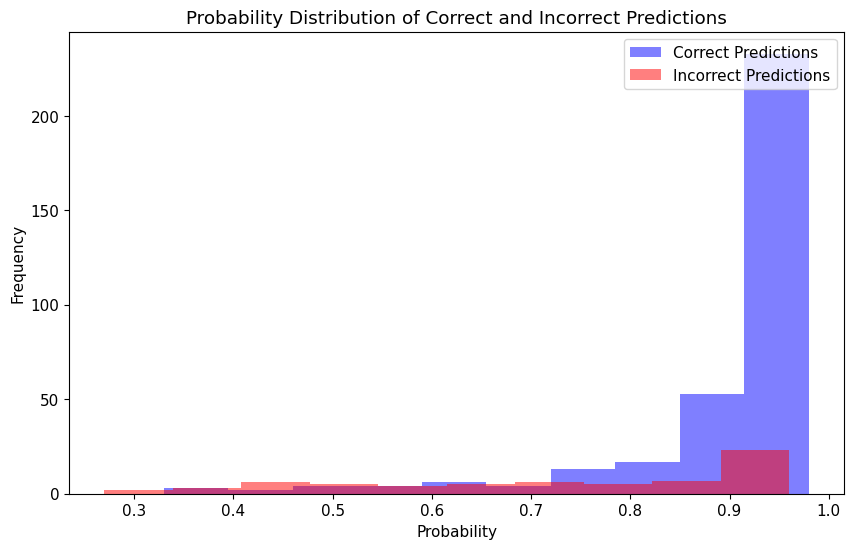

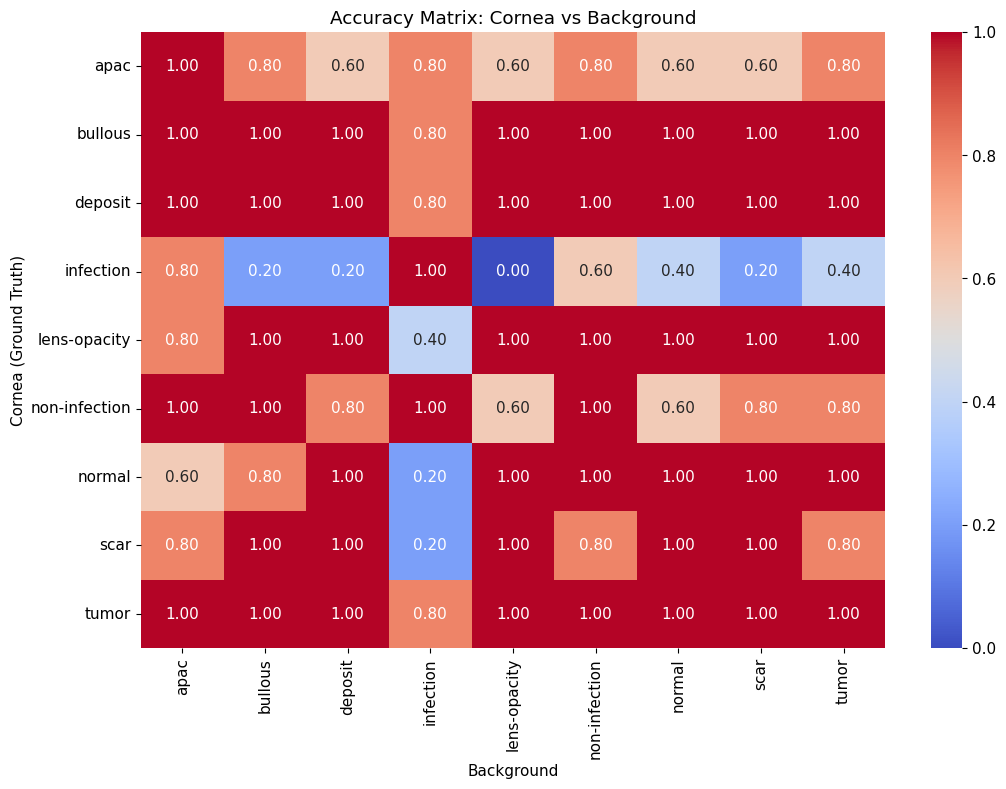

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# CSVファイルの読み込み
file_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/cutmix.csv'
df = pd.read_csv(file_path)

# 正しい判定の割合
correct_predictions = df[df['cornea'] == df['pred']]
accuracy = len(correct_predictions) / len(df)

# 各状態に対する正しい判定の割合
correct_by_cornea = df[df['cornea'] == df['pred']].groupby('cornea').size() / df.groupby('cornea').size()

# 確率の分布
correct_probs = correct_predictions['prob']
incorrect_probs = df[df['cornea'] != df['pred']]['prob']

# ヒストグラムをプロット
plt.figure(figsize=(10, 6))
plt.hist(correct_probs, bins=10, alpha=0.5, label='Correct Predictions', color='blue')
plt.hist(incorrect_probs, bins=10, alpha=0.5, label='Incorrect Predictions', color='red')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Probability Distribution of Correct and Incorrect Predictions')
plt.show()

# グラウンドトゥルースごとの背景に対する正解率マトリックスを作成
matrix = df.pivot_table(index='cornea', columns='background', values='pred', aggfunc=lambda x: (x == df.loc[x.index, 'cornea']).mean())

# マトリックス図をプロット
plt.figure(figsize=(12, 8))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Accuracy Matrix: Cornea vs Background')
plt.xlabel('Background')
plt.ylabel('Cornea (Ground Truth)')
plt.show()


#**Inference cornea vs original images**

In [36]:
import pandas as pd
import re
import os
import cv2
import torch

def process_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    torch_img = model.preprocessing(img)
    with torch.no_grad():
        prediction, logits = model(torch_img)
    if len(prediction[2][0]) > 0:
        top_class = prediction[2][0][0]
        top_prob = prediction[3][0][0]
        return top_class, top_prob
    else:
        return "No detection", 0.0

def folder_main(folder_path, model):
    results = []
    for root, dirs, files in os.walk(folder_path):
        for item in files:
            if item.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                img_path = os.path.join(root, item)
                img_basename = os.path.basename(img_path)

                top_class, top_prob = process_image(img_path, model)

                # Split filename to get groundtruth
                parts = img_basename.split('_')
                if len(parts) >= 2:
                    groundtruth = parts[0]
                    results.append({
                        "basename": img_basename,
                        "cornea_groundtruth": groundtruth,
                        "pred": top_class,
                        "prob": top_prob
                    })

                print(f"Processing image: {img_basename} Top class: {top_class}, Probability: {top_prob:.4f}")

    return pd.DataFrame(results)

if __name__ == '__main__':
    model_path = "/content/drive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img_size = (640, 640)

    folder_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/cornea'
    print(f"Using device: {device}")
    print(f"Processing folder: {folder_path}")

    # Updated class names
    classes = names = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "apac", "lens-opacity", "bullous"]

    model = YOLOV5TorchObjectDetector(model_path, device, img_size=img_size, names=classes)

    df = folder_main(folder_path, model)

    print("\nDataFrame:")
    print(df)
    csv_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/cornea.csv'
    df.to_csv(csv_path, index=False)
    print(f"\nCSV saved to: {csv_path}")

INFO:models.yolo:Fusing layers... 
Fusing layers... 


Using device: cpu
Processing folder: /content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/cornea


INFO:utils.torch_utils:Model Summary: 213 layers, 7034398 parameters, 0 gradients
Model Summary: 213 layers, 7034398 parameters, 0 gradients


[INFO] Model is loaded
Processing image: lens_opacity_43.png Top class: normal, Probability: 0.6700
Processing image: infection_81.png Top class: infection, Probability: 0.7600
Processing image: infection_97.png Top class: infection, Probability: 0.2800
Processing image: deposit_138.png Top class: deposit, Probability: 0.9200
Processing image: deposit_64.png Top class: deposit, Probability: 0.9100
Processing image: deposit_70.png Top class: deposit, Probability: 0.9100
Processing image: infection_29.png Top class: bullous, Probability: 0.7000
Processing image: deposit_77.png Top class: deposit, Probability: 0.9100
Processing image: infection_1.png Top class: infection, Probability: 0.6600
Processing image: infection_75.png Top class: infection, Probability: 0.8400
Processing image: deposit_57.png Top class: deposit, Probability: 0.7900
Processing image: bullous_139.png Top class: bullous, Probability: 0.7600
Processing image: bullous_191.png Top class: bullous, Probability: 0.7900
Proc

In [12]:
import pandas as pd
import os
import cv2
import torch

def process_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    torch_img = model.preprocessing(img)
    with torch.no_grad():
        prediction, logits = model(torch_img)
    if len(prediction[2][0]) > 0:
        top_class = prediction[2][0][0]
        top_prob = prediction[3][0][0]
        return top_class, top_prob
    else:
        return "No detection", 0.0

def process_folders(folder_path_cornea, folder_path_original, model):
    results = []
    for cornea_img_name in os.listdir(folder_path_cornea):
        if cornea_img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            cornea_img_path = os.path.join(folder_path_cornea, cornea_img_name)

            # Construct the corresponding original image name (always .jpg)
            original_img_name = os.path.splitext(cornea_img_name)[0] + '.jpg'
            original_img_path = os.path.join(folder_path_original, original_img_name)

            if not os.path.exists(original_img_path):
                print(f"Warning: Corresponding original image not found for {cornea_img_name}")
                continue

            # Process cornea image
            cornea_top_class, cornea_top_prob = process_image(cornea_img_path, model)

            # Process original image
            original_top_class, original_top_prob = process_image(original_img_path, model)

            # Split filename to get groundtruth
            parts = cornea_img_name.split('_')
            groundtruth = parts[0] if len(parts) >= 2 else "Unknown"

            results.append({
                "basename": cornea_img_name,
                "groundtruth": groundtruth,
                "original_pred": original_top_class,
                "original_prob": original_top_prob,
                "cornea_pred": cornea_top_class,
                "cornea_prob": cornea_top_prob
            })

            print(f"Processing image: {cornea_img_name}")
            print(f"  Original - Top class: {original_top_class}, Probability: {original_top_prob:.4f}")
            print(f"  Cornea   - Top class: {cornea_top_class}, Probability: {cornea_top_prob:.4f}")

    return pd.DataFrame(results)

if __name__ == '__main__':
    model_path = "/content/drive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img_size = (640, 640)

    folder_path_cornea = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/cornea'
    folder_path_original = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/original'

    print(f"Using device: {device}")
    print(f"Processing cornea folder: {folder_path_cornea}")
    print(f"Processing original folder: {folder_path_original}")

    # Updated class names
    classes = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "apac", "lens-opacity", "bullous"]

    model = YOLOV5TorchObjectDetector(model_path, device, img_size=img_size, names=classes)

    df = process_folders(folder_path_cornea, folder_path_original, model)

    print("\nDataFrame:")
    print(df)

    csv_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/comparison_results.csv'
    df.to_csv(csv_path, index=False)
    print(f"\nCSV saved to: {csv_path}")

Using device: cpu
Processing cornea folder: /content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/cornea
Processing original folder: /content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/original


INFO:models.yolo:Fusing layers... 
Fusing layers... 
INFO:utils.torch_utils:Model Summary: 213 layers, 7034398 parameters, 0 gradients
Model Summary: 213 layers, 7034398 parameters, 0 gradients


[INFO] Model is loaded
Processing image: tumor_95.png
  Original - Top class: tumor, Probability: 0.8400
  Cornea   - Top class: tumor, Probability: 0.8900
Processing image: infection_1.png
  Original - Top class: infection, Probability: 0.9600
  Cornea   - Top class: infection, Probability: 0.6600
Processing image: tumor_15.png
  Original - Top class: tumor, Probability: 0.6600
  Cornea   - Top class: tumor, Probability: 0.8500
Processing image: deposit_64.png
  Original - Top class: deposit, Probability: 0.9700
  Cornea   - Top class: deposit, Probability: 0.9100
Processing image: infection_81.png
  Original - Top class: infection, Probability: 0.9700
  Cornea   - Top class: infection, Probability: 0.7600
Processing image: tumor_98.png
  Original - Top class: tumor, Probability: 0.9400
  Cornea   - Top class: tumor, Probability: 0.8200
Processing image: scar_127.png
  Original - Top class: scar, Probability: 0.9200
  Cornea   - Top class: scar, Probability: 0.8100
Processing image: d